Import the libraries

In [446]:
import collections
from ortools.sat.python import cp_model
import math

Define data for problem

In [447]:
import json
with open('hayday_goods.json','r') as file:
    raw_data = json.load(file)

with open('my_machines.json','r') as file:
    my_machines = json.load(file)

with open('my_goods.json','r') as file:
    my_goods = json.load(file)

all_machines = []

for item_name, details in raw_data.items():
    if(details['machine'] not in all_machines):
        all_machines.append(details['machine'])

machines_count = len(all_machines)

declare the model

In [448]:
model = cp_model.CpModel()

In [449]:
class Task:
    def __init__(self,id, name, start, end, machine, l_presences, parent):
        self.id = id
        self.name = name
        self.start = start
        self.end = end
        self.machine = machine
        self.l_presences = l_presences
        self.parent = parent
        self.is_active = model.new_bool_var("is_active"+str(id))
        self.removed_explicit = model.new_bool_var("removed"+str(id))
        

goods_data = ['Mushroom pasta','Pasta carbonara']#martin

machine_to_intervals = collections.defaultdict(list)



horizon = 10000                                                                           
id = 0
queue = []
all_tasks = []

Define the variables

In [450]:

for good in goods_data:
    queue.append((good, id,-1))
    id += 1

while len(queue) != 0:
    current_name, current_id, parent_id = queue.pop(0)
    
    start_var = model.new_int_var(0,horizon,"start"+str(current_id))
    end_var = model.new_int_var(0,horizon,"end"+str(current_id))
   
    interval_var = model.new_interval_var(
        start_var, raw_data[current_name]['time'], end_var, "interval"+str(current_id)
    )
    machine_var = model.new_int_var(0,len(all_machines),"machine"+str(current_id))
    
    l_presences = []
    num_specific_my_machines = my_machines[raw_data[current_name]['machine']]['number']
    for i in range(num_specific_my_machines):
        l_start_var = model.new_int_var(0,horizon,"l_start"+ str(i)+str(current_id))
        l_end_var = model.new_int_var(0,horizon,"l_end"+str(i)+str(current_id))
        l_presence_var = model.new_bool_var(f"l_presence{str(i)}_{str(current_id)}")
        l_interval_var = model.new_optional_interval_var(
            l_start_var, raw_data[current_name]['time'], l_end_var, l_presence_var, "interval"+str(current_id)
        )
        
        model.Add(start_var == l_start_var).OnlyEnforceIf(l_presence_var)
        model.Add(end_var == l_end_var).OnlyEnforceIf(l_presence_var)
        model.Add(machine_var == i).OnlyEnforceIf(l_presence_var)
        l_presences.append(l_presence_var)
        machine_to_intervals[raw_data[current_name]['machine']+str(i)].append(l_interval_var)
    model.add_exactly_one(l_presences)

  
    all_tasks.append(Task(id,current_name,start_var,end_var,machine_var,l_presences,parent_id))

    if(parent_id != -1):
        model.add(
            all_tasks[parent_id].start >= all_tasks[current_id].end
        ).only_enforce_if(all_tasks[parent_id].is_active, all_tasks[current_id].is_active)
        model.add_implication(all_tasks[parent_id].is_active.Not(),all_tasks[current_id].is_active.Not())
        model.add_bool_and(
            all_tasks[current_id].is_active.Not(),
            all_tasks[parent_id].is_active
        ).OnlyEnforceIf(all_tasks[current_id].removed_explicit)

        model.add_bool_or(
            all_tasks[current_id].is_active,
            all_tasks[parent_id].is_active.Not()
        ).OnlyEnforceIf(all_tasks[current_id].removed_explicit.Not())
    else:
        model.add(all_tasks[current_id].removed_explicit == all_tasks[current_id].is_active.Not())

    
    
    for ing, ing_qty in raw_data[current_name]['ingredients'].items():
        if(ing != current_name):
            for i in range(ing_qty):
                queue.append((ing, id, current_id))
                id += 1
                


Define the constraints

In [451]:
for task in all_tasks:
        temp_arr = []
        inactive_parents = []
        for t in all_tasks:
            if(t.name == task.name):
                print(task.name)
                temp_arr.append(t.removed_explicit)
                inactive_parents.append(all_tasks[t.parent].is_active.Not())
        if(task.name in my_goods):
            if(int(my_goods[task.name]['number']) > 0):
                num_of_inactive_parents = sum(inactive_parents)
                min_var = model.NewIntVar(0, 10000, 'min_var')
                if(task.parent != -1):
                    model.AddMinEquality(min_var, [len(temp_arr)-num_of_inactive_parents, my_goods[task.name]['number']])
                else:
                    model.AddMinEquality(min_var, [len(temp_arr), my_goods[task.name]['number']])

                model.Add(sum(temp_arr) == min_var)
            else:
                model.Add(sum(temp_arr) == 0)
        else:
            model.Add(sum(temp_arr) == 0)
    

import re

def get_trailing_number(s):
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group(0)) 
    else:
        return None

for machine in machine_to_intervals.keys():
    model.add_no_overlap(machine_to_intervals[machine])

for machine in machine_to_intervals.keys():
    intervals = machine_to_intervals[machine]
    for i in intervals:
        for j in intervals:
            if(i != j):
                id_i = int(i.Name()[len("interval"):])
                id_j = int(j.Name()[len("interval"):])

                good_i = all_tasks[id_i].name
                good_j = all_tasks[id_j].name

                a =  model.NewBoolVar('a')
                model.add(all_tasks[id_j].start >= all_tasks[id_i].end).OnlyEnforceIf(a)
                model.add(all_tasks[id_j].start < all_tasks[id_i].end).OnlyEnforceIf(a.Not())
                
                b = model.NewBoolVar('b')
                model.add(all_tasks[id_i].start >= all_tasks[id_j].end).OnlyEnforceIf(b)
                model.add(all_tasks[id_i].start < all_tasks[id_j].end).OnlyEnforceIf(b.Not())
                
                model.AddBoolOr(a,b).OnlyEnforceIf(all_tasks[id_i].l_presences[get_trailing_number(machine)],all_tasks[id_j].l_presences[get_trailing_number(machine)])

Mushroom pasta
Pasta carbonara
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Mushroom
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Goat milk
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Fresh pasta
Bacon
Bacon
Bacon
Bacon
Egg
Egg
Egg
Egg
Egg
Egg
Egg
Cheese
Egg
Egg
Egg
Egg
Egg
Egg
Egg
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat
Wheat

Define the objective

In [452]:

obj_var = model.new_int_var(0, horizon, "makespan")

cand_ends = []
for i in range(id):
        c = model.NewIntVar(0, horizon, f"cand_end_{i}") 
        model.Add(c == 0).only_enforce_if(all_tasks[i].is_active.Not())
        model.Add(c == all_tasks[i].end).only_enforce_if(all_tasks[i].is_active)
        cand_ends.append(c)

# 2) now max over those “masked” ends
model.AddMaxEquality(obj_var, cand_ends)
model.minimize(obj_var)

Invoke solver

In [453]:
solver = cp_model.CpSolver()

  
status = solver.solve(model)

print(solver.Value(obj_var))


745


Display results

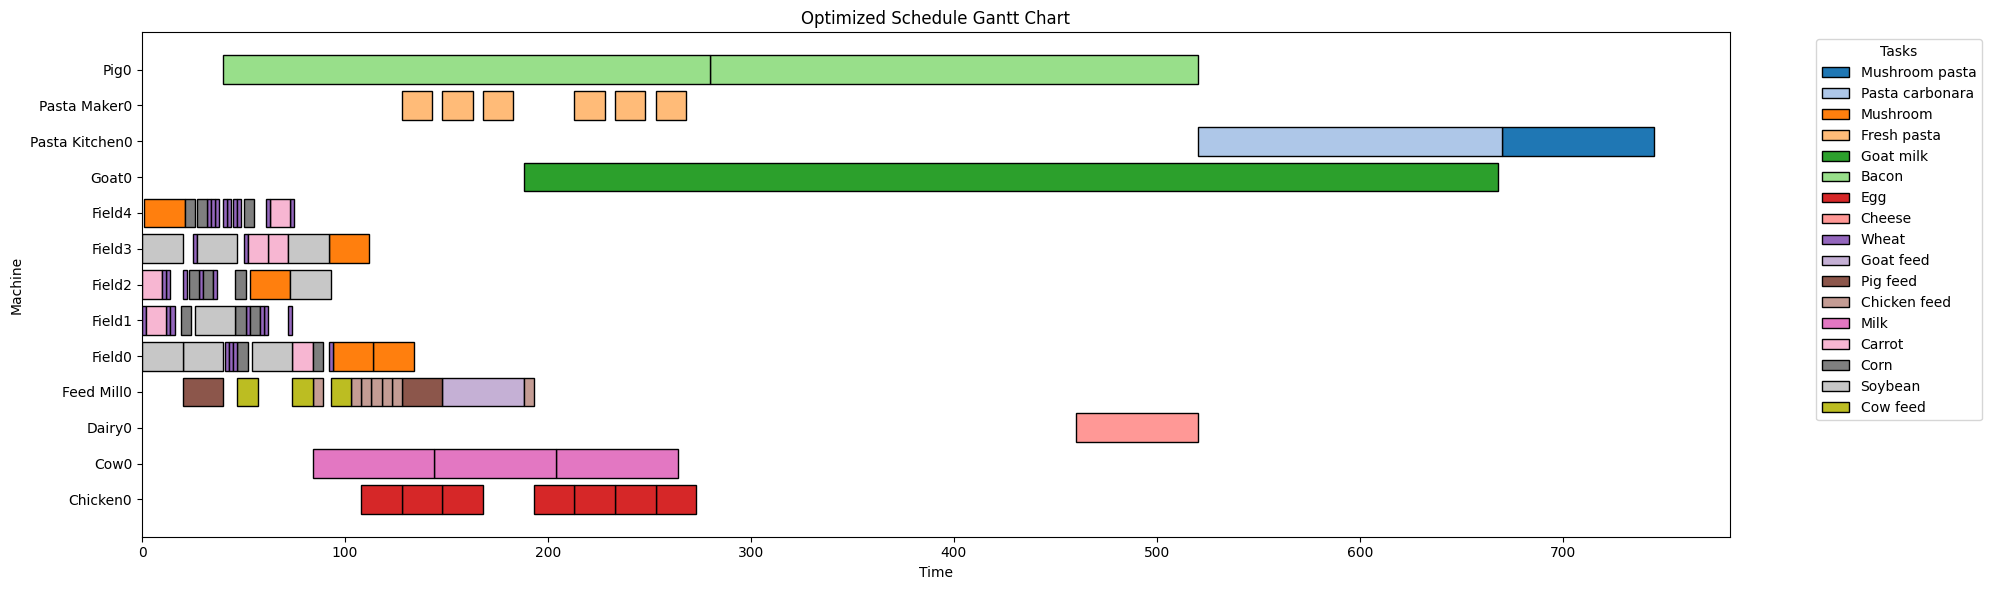

In [454]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    # Collect schedule data for plotting
    schedule_data = []
    for i in range(id):
        if(solver.Value(all_tasks[i].is_active)):
            start = solver.Value(all_tasks[i].start)
            end = solver.Value(all_tasks[i].end)
            machine = raw_data[all_tasks[i].name]['machine']+ str(solver.Value(all_tasks[i].machine))
            schedule_data.append((all_tasks[i].name, start, end, machine))
     
    fig, ax = plt.subplots(figsize=(20, 6))  # Wider figure for visibility

    # Unique machine list and positions
    machines = sorted(set(item[3] for item in schedule_data))
    y_positions = {machine: idx for idx, machine in enumerate(machines)}

    # Assign colors by task name
    colors = {}
    for idx, (task_name, _, _, _) in enumerate(schedule_data):
        if task_name not in colors:
            colors[task_name] = plt.cm.tab20(len(colors) % 20)

    # Draw bars with scaling
    for task_name, start, end, machine in schedule_data:
        ax.barh(
            y_positions[machine],
            (end - start),
            left=start,
            color=colors[task_name],
            edgecolor='black'
        )

    # Create legend
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=task)
                       for task, color in colors.items()]
    ax.legend(handles=legend_elements, title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format chart
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel(f"Time")
    ax.set_ylabel("Machine")
    ax.set_title("Optimized Schedule Gantt Chart")
    plt.tight_layout()
    plt.show()
else:
    print("frick")
